# Homework 4 (100 Points)

### Collaborators: Shivangi, Sarah Bonna

## Exercise 1 (40pts)

In this exercise we will implement a Natural Language Processing (NLP) system using binary logistic regression.

The data you will be working with comes from the [Yelp Dataset](https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings. Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$

### Part 1 (20pts)

a) Implement a function to trim out-of-vocabulary words from the reviews. Your function should return an nd array of the same dimension and dtype as the original loaded dataset. (10pts)

In [231]:
import csv
import numpy as np

VECTOR_LEN = 300   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

################################################################################
# We have provided you the functions for loading the tsv and txt files. Feel   #
# free to use them! No need to change them at all.                             #
################################################################################


def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset

def load_tsv_dataset_for_embeddings(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                     dtype=[('id', 'f8'), ('text', 'O')])

    return dataset

def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map


def trim_reviews(path_to_dataset):
    word2vec = load_feature_dictionary("./data/word2vec.txt")
    data = load_tsv_dataset(path_to_dataset)
    data_cleaned=[]
    for text in data:
        row=[]
        tokens = text[1].split(" ")
        matching_tokens = [token for token in tokens if token in word2vec.keys()]
        row.append(text[0])
        row.append(" ".join(matching_tokens))
        data_cleaned.append(row)
    return data_cleaned

trim_train = trim_reviews("./data/train_small.tsv")
trim_test = trim_reviews("./data/test_small.tsv")

b) Implement the embedding and store it to a `.tsv` file where the first column is the label and the rest are the features from the embedding. Round all numbers to 6 decimal places. `embedded_train_small.tsv` and `embedded_test_small.tsv` contain the expected output of your function. (10pts)

In [232]:
def embed_reviews(trimmed_dataset):
    embedded_dataset=[]
    word2vec = load_feature_dictionary("./data/word2vec.txt")
    for text in trimmed_dataset:
        row=[]
        words = text[1].split()
        word_vectors = [word2vec[word] for word in words if word in word2vec]
        feature_vector = np.round(np.mean(word_vectors, axis=0),6)
        row.append(text[0])
        row.append(feature_vector)
        embedded_dataset.append(row)
    return embedded_dataset

def save_as_tsv(dataset, filename):
    with open(filename, 'w+') as f:
        for row in dataset:
            f.write(str(row[0]) + '\t' + '\t'.join(map(str, row[1])) + '\n')
    return

embedded_train = embed_reviews(trim_train)
embedded_test = embed_reviews(trim_test)

#et_o=load_tsv_dataset_for_embeddings("./data/output/embedded_train_small.tsv")
save_as_tsv(embedded_train, "./data/output/embedded_train_small.tsv")
save_as_tsv(embedded_test, "./data/output/embedded_test_small.tsv")

### Part 2 (20pts)

In this part we'll be implementing Gradient Descent for binary Logistic Regression Classifier.

Some rules:

1. Include an intercept term in your model. You must consider the bias term as part of the weight vector and not a separate term to keep track of.
2. Initialize all model parameters to 0
3. Use vector and matrix multiplication

The expected `metrics.txt` from the dataset with `500` epochs and `0.001` learning rate is:

```
error(train): 0.000000
error(test): 0.625000
```

We will be testing your code on other, larger datasets.

In [233]:
import numpy as np

def load_tsv_dataset(file):
    return np.loadtxt(file, delimiter='\t', encoding='utf-8')


def sigmoid(x):
    e = np.exp(x)
    return e / (1 + e)


def gd(theta, X, y, learning_rate):
    # TODO: implement in vector form
    grad = (1/len(y)) * np.dot(X.T, (sigmoid(np.dot(X, theta)) - y)) + (theta/len(y))*theta
    theta -= learning_rate * grad
    return theta


def train(theta, X, y, num_epoch, learning_rate):
    for epoch in range(num_epoch):
        theta = gd(theta, X, y, learning_rate)
    return theta


def predict(theta, X):
    # TODO: implement in vector form
    y_pred = sigmoid(np.dot(X, theta))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    return y_pred


def compute_error(y_pred, y):
    # TODO: implement in vector form
    return np.mean(np.abs(y - y_pred))


def write_metrics(train_err, test_err, metrics_out):
    with open(metrics_out, 'w+') as f:
        w = "error(train): " + "{:.6f}".format(train_err) + "\n"
        w += "error(test): " + "{:.6f}".format(test_err) + "\n"
        f.write(w)
    return


def logistic_reg(formatted_train, formatted_test, metrics_out, num_epochs, learning_rate):
    X = load_tsv_dataset(formatted_train)
    y = X[:, 0]
    X = np.insert(X[:, 1:], 0, 1, axis=1)
    theta = np.zeros(X.shape[1])

    learned_theta = train(theta, X, y, num_epochs, learning_rate)
    train_pred = predict(learned_theta, X)
    train_err = compute_error(train_pred, y)

    X_test = load_tsv_dataset(formatted_test)
    y_test = X_test[:, 0]
    X_test = np.insert(X_test[:, 1:], 0, 1, axis=1)
    test_pred = predict(learned_theta, X_test)
    test_err = compute_error(test_pred, y_test)

    write_metrics(train_err, test_err, metrics_out)
    return


logistic_reg("./data/output/embedded_train_small.tsv", "./data/output/embedded_test_small.tsv", "./data/output/metrics.txt", 500, 0.01)

In [234]:
with open('./data/output/metrics.txt', 'r') as f:
    print(f.read())

error(train): 0.000000
error(test): 0.625000



## Exercise 2 (60 Points)

For this exercise, recall the lab's kaggle competition where you predicted if a cookie was defective or not (assuming you attend labs). For more information on the data and details, [click here to view the competition and data details](https://www.kaggle.com/competitions/cs506-lab-defective-cookie-detection/data)

However, what we will do differently here is check if two of the features were correlated. This is important because if two features are correlated, then we can remove one of the features and still get the same information. This is part of the feature selection process.

### Loading in the Data

For this exercise, we are interested in the two features `Texture Hardness` and `Texture Chewiness` and want to see if they are related. To do this, we will load in the data and create a scatter plot of the two features.

**a)** (1 Point) Download the kaggle data from the link above and read in the `csv` files `cookie_train.csv` and `cookie_test.csv`

In [235]:
#Code in this cell
import pandas as pd
cookie_test = pd.read_csv("data/cookie/cookie_test.csv")
cookie_train = pd.read_csv("data/cookie/cookie_train.csv")

### Combining Training and Testing Data

The lab did not have a lot of cookies for the training set, so what we will do is combine the training and testing data together without any loss of generality.

**b)** (3 Point) Combine the training and testing data together into a single dataframe called `cookie_data` and plot the scatter plot for `Texture Chewiness` (our y or our response variable) and `Texture Hardness` (our x or our explanatory variable). Make sure to label your axes and give your plot a title.

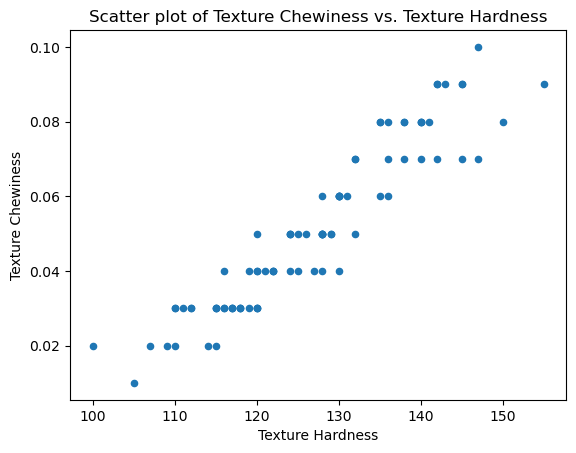

In [236]:
#Code in this cell
import matplotlib.pyplot as plt

cookie_data = pd.concat([cookie_train, cookie_test], ignore_index=True)

cookie_data.plot.scatter(x='Texture Hardness', y='Texture Chewiness')
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Scatter plot of Texture Chewiness vs. Texture Hardness')
plt.show()


### Checking If We Can Do Linear Regression

It is important to check all requirements/assumptions for linear regression are met before we do linear regression. One of the requirements is that the explanatory variable and response variable are linearly related, which we checked by noticing the scatter plot was linear. However, there is much more to check!

#### Checking for Normality
It is important to check that the response variable is normally distributed. This is important for hypothesis testing and relates to the idea of linear regression being an unbiased, minimum variance estimator (if you're interested in this, check out the course CAS MA 582).


**c) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the normality assumption. State whether the normality assumption is met or not. If it is not met, state what can we do to fix this.

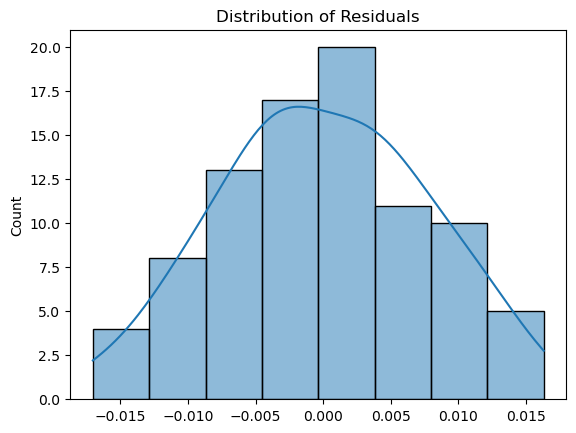

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

X = cookie_data['Texture Hardness']
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, sm.add_constant(X)).fit()

y_pred = model.predict(sm.add_constant(X))
residuals = y - y_pred

sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

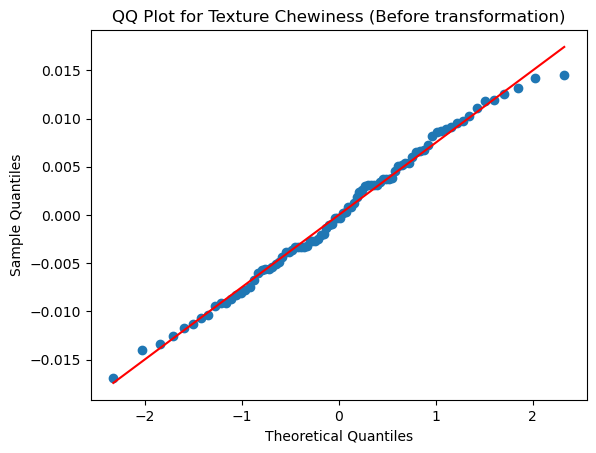

In [238]:
import scipy as sc
theoretical_quantiles = sc.stats.norm.ppf(np.linspace(0.01, 0.99, num=len(residuals)))
sample_quantiles = np.quantile(residuals, np.linspace(0.01, 0.99, num=len(residuals)))

model1 = sm.OLS(sample_quantiles, sm.add_constant(theoretical_quantiles)).fit()

plt.scatter(theoretical_quantiles, sample_quantiles)
plt.plot(theoretical_quantiles, model1.predict(), color='red')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot for Texture Chewiness (Before transformation)')
plt.show()

Plotting the histogram with the kde curve shows us that the original data is normally distributed to an extent.

#### Checking for Homoscedasticity
It is important to check that the variance of the response variable is the same across all values of the explanatory variable. Otherwise, the confidence around a predicted value of the response variable will vary depending on the explanatory variable value.

**d) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the homoscedasticity assumption. State whether the homoscedasticity assumption is met or not. If it is not met, state what can we do to fix this.

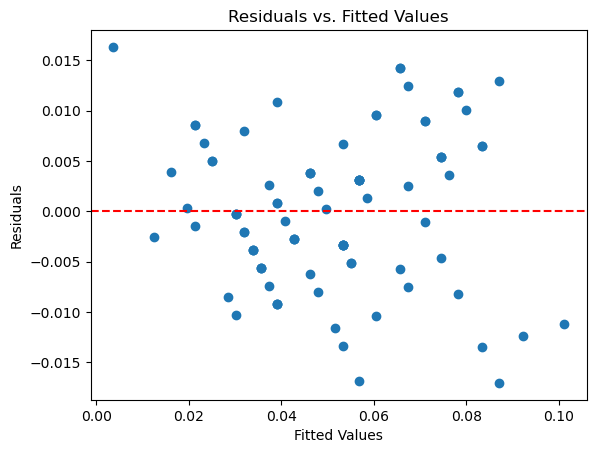

In [239]:
X = cookie_data['Texture Hardness']
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, sm.add_constant(X)).fit()

y_pred = model.predict(sm.add_constant(X))
residuals = y - y_pred
plt.scatter(y_pred, residuals)

plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.show()

In order to find the linear relationship between the predictor and the dependent variables, I used OLS (Ordinary Least Squares) model. The Residuals are the differences between the actual values of the dependent variable and the predicted values whichh I have plotted to find out if the data follows homoscedasticity. 

From the above plot, we can see that the residual vs fitted plot is not completely random along the `y=0` line. so the assumption of homoscedasticity doesn't hold true.

#### Checking for Independence
It is important to check that the explanatory variable and response variable are independent. Otherwise, the model isn't really best fit with a line. To do so, we will use the Durbin-Watson test.

**e) (5 Points)** Use the Durbin-Watson test to determine if the explanatory variable and response variable are independent. State whether if the independence assumption is met or not. If it is not met, state what can we do to fix this. You may use any library to do this, and for more information, check out [this link](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp).

In [240]:
#Code in this cell
X = cookie_data['Texture Hardness']
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, X).fit()

test_result = sm.stats.stattools.durbin_watson(model.resid)
print(test_result)
if test_result < 1.5:
    print("Positive autocorrelation")
elif test_result > 2.5:
    print("Negative autocorrelation")
else:
    print("No autocorrelation")

2.6104905730803654
Negative autocorrelation


We see that the `Texture Hardness` is `negatively correlted` with `Texture Chewiness` which means that if `Texture Hardness` increases, `Texture Chewiness` decreases

#### Adjusting the Model
If you think any of the assumptions are not met, then you should respectively fix the model.

**f) (6 Points)** If you think atleast one of the assumptions were not met, then adjust the model how you described you would. Otherwise, proceed to the next step and in the cell below, write "No adjustments were made to the model". However, if you do adjust the model, then in the cell below, justify why your adjustments is appropriate (i.e. plot the new graphs and statistics found above). You may add as many cells as you like.

In [241]:
#cookie_data['Texture Hardness'] = np.power(cookie_data['Texture Hardness'], 0.5)
cookie_data['Texture Hardness'] = np.log(cookie_data['Texture Hardness'])
model = sm.OLS(cookie_data['Texture Chewiness'], sm.add_constant(cookie_data['Texture Hardness'])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     584.7
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           4.02e-40
Time:                        21:47:23   Log-Likelihood:                 302.62
No. Observations:                  88   AIC:                            -601.2
Df Residuals:                      86   BIC:                            -596.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.0302      0.045  

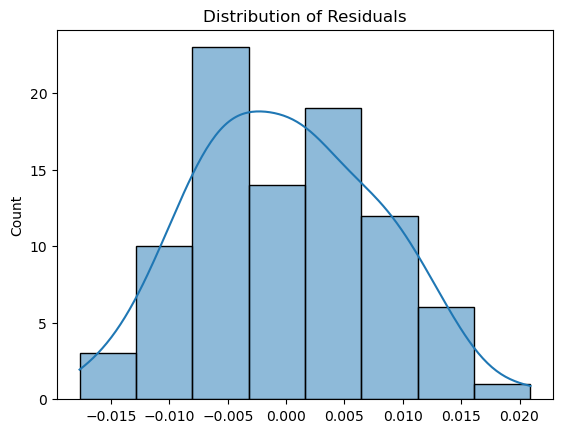

In [242]:
X = cookie_data['Texture Hardness']
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, sm.add_constant(X)).fit()

y_pred = model.predict(sm.add_constant(X))
residuals = y - y_pred

sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

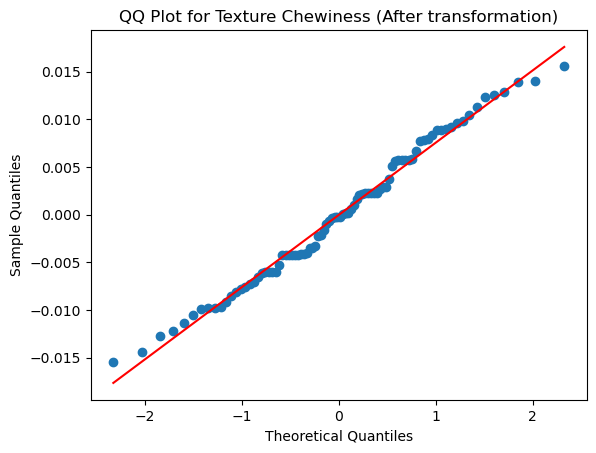

In [243]:
theoretical_quantiles = sc.stats.norm.ppf(np.linspace(0.01, 0.99, num=len(residuals)))
sample_quantiles = np.quantile(residuals, np.linspace(0.01, 0.99, num=len(residuals)))

model1 = sm.OLS(sample_quantiles, sm.add_constant(theoretical_quantiles)).fit()

plt.scatter(theoretical_quantiles, sample_quantiles)
plt.plot(theoretical_quantiles, model1.predict(), color='red')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot for Texture Chewiness (After transformation)')
plt.show()

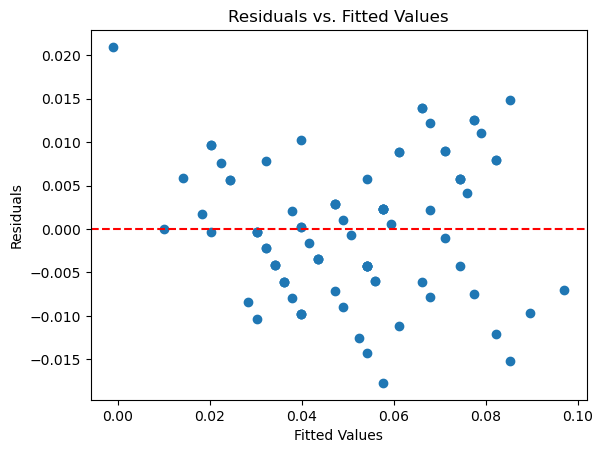

In [244]:
X = cookie_data['Texture Hardness']
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, sm.add_constant(X)).fit()

y_pred = model.predict(sm.add_constant(X))
residuals = y - y_pred
plt.scatter(y_pred, residuals)

plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.show()

After using `power log` transformation, as it worked better than the other methods I tried, like sqrt,log,boxcox transformations, we can see from the histogram chart of the residuals, that the outliers have been reduced. And from the model summary, we can see that the `Durbin-Watson score` is `2.353`, which is greater than `1.5` and lesser than `2.5`, so there is `no autocorrelation`

### Hypothesis Testing
Now that we have a model that is appropriate, we can do hypothesis testing. We will be using the Linear Regression t-test to test if the explanatory variable is a significant predictor of the response variable.

**g) (5 Points)** Use the Linear Regression t-test to determine if the explanatory variable `Texture Hardness` is a significant predictor of the response variable `Texture Chewiness`. State whether if the explanatory variable is a significant predictor of the response variable or not using an alpha significance level of $\alpha = 0.05$, the null hypothesis $\beta_{hardness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

In [245]:
#Your code in this cell
X = sm.add_constant(cookie_data['Texture Hardness'])
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, X).fit()

t_value = model.tvalues[1]
p_value = model.pvalues[1]
p_gt_abs_t_value = float(model.summary().tables[1].data[1][4])

print("t-value:" +str(t_value))
print("p-value:" +str(p_value))
print("p>|t|:" +str(p_gt_abs_t_value))
alpha = 0.05

if p_gt_abs_t_value < alpha:
    print("The feature variable 'Texture Hardness' is a significant predictor of the predictor variable 'Texture Chewiness'.")
else:
    print("The feature variable 'Texture Hardness' is not a significant predictor of the predictor variable 'Texture Chewiness'.")



t-value:24.18151553521705
p-value:4.017398526064704e-40
p>|t|:0.0
The feature variable 'Texture Hardness' is a significant predictor of the predictor variable 'Texture Chewiness'.


Looking at the summary above, we see that the p-value (P>|t|) of `Texture Hardness` using the `Texture Chewiness` as the dependent variable is 0.000. 

This means that the p-value is very small, smaller than the alpha significance level of $\alpha = 0.05$.


This is strong evidence against the null hypothesis and shows that the variable `Texture Hardness` is a significant predictor of the response variable ` Texture Chewiness`. Hence, the null hypothesis $\beta_{hardness} = 0$ can be rejected.

### Adding a New Feature
Now that we have determined that the explanatory variable is a significant predictor of the response variable, you noticed the fit isn't 100% perfect still (e.g. your model is not capturing all the variation in the data). You think that there is another feature that can help improve the model. You think that the feature `Taste Sweetness` can help improve your model. You want to test if this is true. You may assume that all the assumptions are met for this new model to conduct linear regression.

**h) (10 Points)** Now that you have two features to predict your response variable, you will have to use multiple linear regression. Use the `statsmodels` library to do multiple linear regression. Then, determine if the explanatory variables `Texture Hardness` and `Taste Sweetness` are significant predictors of the response variable `Texture Chewiness` using an alpha significance level of $\alpha = 0.001$, the null hypothesis $\beta_{hardness} = 0$ and $\beta_{sweetness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$ and $\beta_{sweetness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

Moreover, justify whether the overall model is significant or not using the F-test with the same $\alpha$ given above. If it is not, state what can we do to fix this.

_You may use the transformed model made (if one was made) from the previous parts and add this new feature to it._

In [246]:
#Your code in this cell
X = sm.add_constant(cookie_data[['Texture Hardness', 'Taste Sweetness']])
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, X).fit()
alpha = 0.001

print(model.pvalues[1])
p_gt_abs_t_value_hardness = float(model.summary().tables[1].data[1][4])
print("p>|t| for hardness:" +str(p_gt_abs_t_value_hardness))
if p_gt_abs_t_value_hardness < alpha:
    print("The feature variable 'Texture Hardness' is a significant predictor of the predictor variable 'Texture Chewiness'.")
else:
    print("The feature variable 'Texture Hardness' is not a significant predictor of the predictor variable 'Texture Chewiness'.")


p_gt_abs_t_value_sweetness = float(model.summary().tables[1].data[2][4])
print("p>|t| for sweetness:" +str(p_gt_abs_t_value_sweetness))
if p_gt_abs_t_value_sweetness < alpha:
    print("The feature variable 'Taste Sweetness' is a significant predictor of the predictor variable 'Texture Chewiness'.")
else:
    print("The feature variable 'Taste Sweetness' is not a significant predictor of the predictor variable 'Texture Chewiness'.")

if p_gt_abs_t_value_hardness < alpha and p_gt_abs_t_value_sweetness < alpha:
    print("Both feature variables are significant predictors of the predictor variable.")
else:
    print("At least one of the explanatory variables is not a significant predictor of the predictor variable.")

p_value_f = model.f_pvalue
if p_value_f < alpha:
    print("The overall model is significant.")
else:
    print("The overall model is not significant.")


3.3802313909162803e-15
p>|t| for hardness:0.0
The feature variable 'Texture Hardness' is a significant predictor of the predictor variable 'Texture Chewiness'.
p>|t| for sweetness:0.0
The feature variable 'Taste Sweetness' is a significant predictor of the predictor variable 'Texture Chewiness'.
Both feature variables are significant predictors of the predictor variable.
The overall model is significant.


The p-value of the model is 7.312011412914803e-07, which is smaller than the alpha significance level of $\alpha = 0.001$. This is strong evidence that the overall model is significant.

### Interpretation
It is important to be able to interpret the results of the model. This is important because it allows us to understand the model and how it works. It also allows us to understand the relationship between the predictors and the response variable, and this applies to not just linear regression, but all learning models.

**i) (10 Points)** Interpret the coefficients of the model made in part **h**. What do they mean? What do they represent? What do they tell us about the relationship between the predictors and the response variable? If your code output in part h does not provide these results, you are welcome to use any library here to do so.

In [247]:
#Your code in this cell if you need it
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     547.4
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           2.81e-49
Time:                        21:47:24   Log-Likelihood:                 327.98
No. Observations:                  88   AIC:                            -650.0
Df Residuals:                      85   BIC:                            -642.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.6036      0.062  

The `R-squared value` of `0.928` indicates that the model explains 92.8% of the variance in the dependent variable. This is a high value, suggesting that the model is a good fit for the data.

The coefficients for the predictor variables indicate the strength and direction of their relationship with the dependent variable. The coefficient for `Texture Hardness` is 0.1295, indicating that for every one unit increase in `Texture Hardness`, `Texture Chewiness` increases by 0.1295 units, holding all other variables constant. The coefficient for `Taste Sweetness` is 0.0111, indicating that for every one unit increase in `Taste Sweetness`, `Texture Chewiness` increases by 0.0111 units, holding all other variables constant.

The `p-values` for both predictor variables are `less than 0.05`, indicating that they are statistically significant in predicting `Texture Chewiness`. 

The `Durbin-Watson` value of `1.92` suggests that there is `no significant autocorrelation` in the residuals of the model. 

The equation to predict Texture Chewiness based on the above multiple linear regression model is:

`Texture Chewiness = -0.6036 + 0.1295(Texture Hardness) + 0.0111(Taste Sweetness)`

### Using Taste Bitterness over Taste Sweetness
You think that the feature `Taste Bitterness` can help improve your model since `Taste Sweetness` wasn't it.

For this section, you will continue to use your fixed/adjusted features for `Texture Hardness` and `Texture Chewiness`.

**j) (10 Points)** Plot 2 scatter plots: `Taste Bitterness` vs your possibly adjusted `Texture Chewiness` and `Taste Bitterness` vs your possibly adjusted `Texture Hardness`. Given these plots, propose an appropriate model. Justify your answer by fitting it and seeing its accuracy (you can use any metric to prove so), showing appropriate models/graphs, and ensuring assumptions are satisfied (if any). You may use any library to do this.

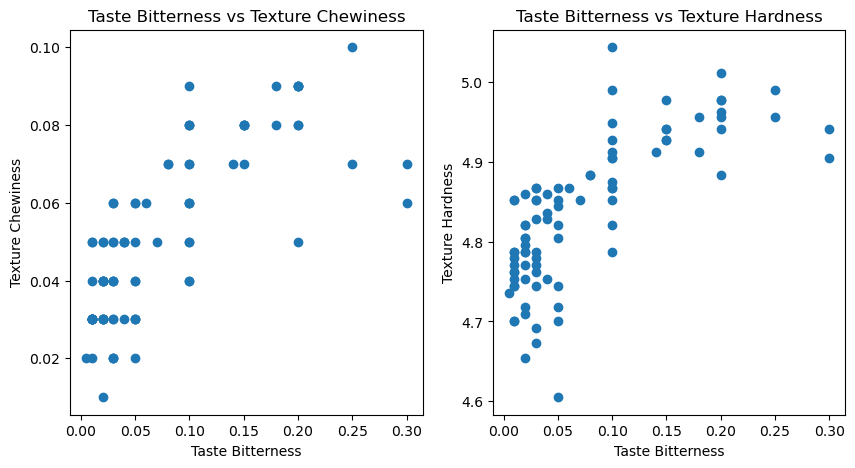

In [248]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(cookie_data["Taste Bitterness"], cookie_data["Texture Chewiness"])
ax1.set_xlabel("Taste Bitterness")
ax1.set_ylabel("Texture Chewiness")
ax1.set_title("Taste Bitterness vs Texture Chewiness")
ax2.scatter(cookie_data["Taste Bitterness"], cookie_data["Texture Hardness"])
ax2.set_xlabel("Taste Bitterness")
ax2.set_ylabel("Texture Hardness")
ax2.set_title("Taste Bitterness vs Texture Hardness")

plt.show()


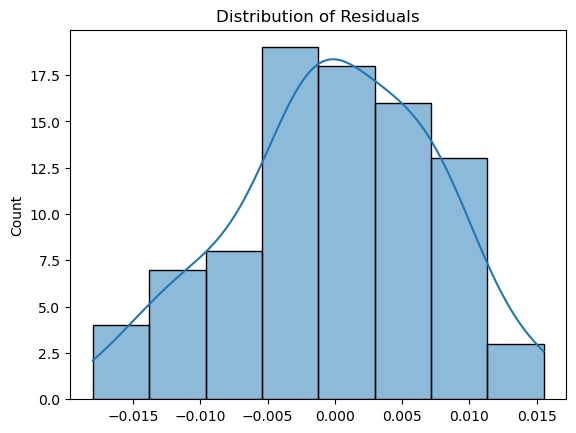

In [249]:
X = cookie_data[['Texture Hardness', 'Taste Bitterness']]
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, sm.add_constant(X)).fit()

y_pred = model.predict(sm.add_constant(X))
residuals = y - y_pred

sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

In [250]:
cookie_data['Taste Bitterness'] = np.power(cookie_data['Taste Bitterness'], 0.5)
cookie_data['Taste Bitterness'] = np.log(cookie_data['Taste Bitterness'])

# Drop any rows with missing or NaN values
cookie_data.dropna(inplace=True)

X = sm.add_constant(cookie_data[['Texture Hardness', 'Taste Bitterness']])
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, X).fit()


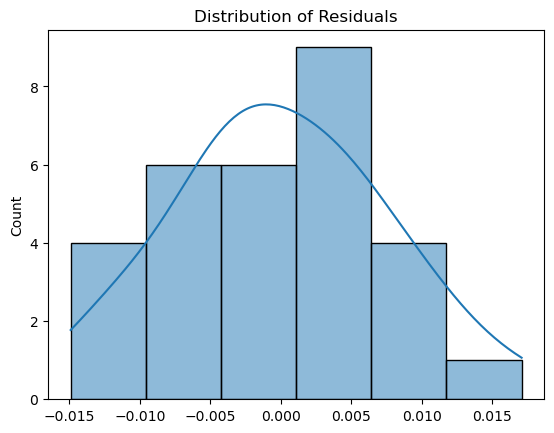

In [251]:
X = cookie_data[['Texture Hardness', 'Taste Bitterness']]
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, sm.add_constant(X)).fit()

y_pred = model.predict(sm.add_constant(X))
residuals = y - y_pred

sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

In [252]:
#Code in this cell
X = cookie_data[['Texture Hardness', 'Taste Bitterness']]
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, X).fit()

test_result = sm.stats.stattools.durbin_watson(model.resid)
print(test_result)
if test_result < 1.5:
    print("Positive autocorrelation")
elif test_result > 2.5:
    print("Negative autocorrelation")
else:
    print("No autocorrelation")

2.0136453560752363
No autocorrelation


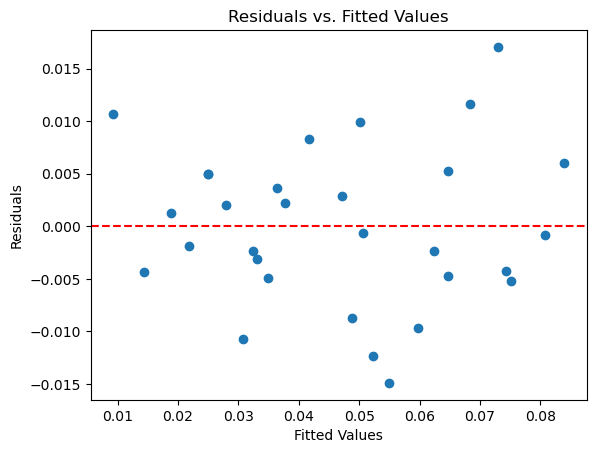

In [253]:
model = sm.OLS(y, sm.add_constant(X)).fit()

y_pred = model.predict(sm.add_constant(X))
residuals = y - y_pred
plt.scatter(y_pred, residuals)

plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.show()

In [254]:
X = cookie_data[['Texture Hardness', 'Taste Bitterness']]
X = sm.add_constant(X)
X['Texture Hardness^2'] = X['Texture Hardness'] ** 2
X['Taste Bitterness^2'] = X['Taste Bitterness'] ** 2
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, X).fit()

print(model.summary())

y_pred = model.predict(X)

mse = np.mean((y - y_pred)**2)
print(f"Mean Squared Error: {mse}")

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     53.81
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           6.34e-12
Time:                        21:47:24   Log-Likelihood:                 106.14
No. Observations:                  30   AIC:                            -202.3
Df Residuals:                      25   BIC:                            -195.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.2808      2

In [258]:
X = cookie_data[['Texture Hardness', 'Taste Sweetness', 'Taste Bitterness']]
X = sm.add_constant(X)
X['Texture Hardness^2'] = X['Texture Hardness'] ** 2
X['Taste Bitterness^2'] = X['Taste Bitterness'] ** 2
X['Taste Sweetness^2'] = X['Taste Sweetness'] ** 2
y = cookie_data['Texture Chewiness']
model = sm.OLS(y, X).fit()

print(model.summary())

y_pred = model.predict(X)

mse = np.mean((y - y_pred)**2)
print(f"Mean Squared Error: {mse}")

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     44.05
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           1.77e-11
Time:                        21:53:29   Log-Likelihood:                 110.07
No. Observations:                  30   AIC:                            -206.1
Df Residuals:                      23   BIC:                            -196.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0117      2

After adding `Taste Bitterness` instead of `Taste Sweetness` for predicting `Texture Chewiness`, I plotted the histogram of the residuals, which showed that the values were not normalized. So, I applied the same `power log` transformation to `Taste Bitterness`. Plotting the residuals post which, shows a better normalized curve on the histogram, with no autocorrelation from Durbin-Watson.

The scatter plot for `Taste Bitterness` against both `Texture Chewiness` and `Texture Hardness` show a non linear relationship. hence, in order to capture the non-linearity, the squared terms of the exploratory variables are also needed in the regression model for predicting `Texture Chewiness`

For the model, I used multiple linear regression using the Ordinary Least Squares (OLS) method. The independent variables used in the regression are `Texture Hardness`, and `Taste Bitterness`, and their respective squared terms are also included in the model. The `Mean Squared Error` is 4.948531009180381e-05 which indicates good prediction by the model.

Adding `Taste Sweetness` to the independent variables list, to predict `Taste Chewiness` improved the r-squared score from `0.896` to `0.920`, decreased the autocorrelation.

## Bonus (20pts)

Lasso Regression is a modification of Regression that adds a regularization penalty to the the parameter $\mathbf{\beta}$ learned by the model. The loss function for Lasso is the following:

$$\mathcal{L}(\mathbf{\beta}) = \Vert \mathbf{y} - X\mathbf{\beta} \Vert^2 + \lambda \Vert \mathbf{\beta} \Vert = \beta^T X^T X \beta - 2\mathbf{\beta}^TX^T\mathbf{y}  + \mathbf{y}^T\mathbf{y} + \lambda \Vert \mathbf{\beta} \Vert$$

Where $\lambda$ is a tuning parameter specified by the user.

Using worksheet 17 as a guide:

1. create an animation like in part c) for Lasso Regression. [15pts]
2. create at least two more animations using different values for $\lambda$ and the true $\mathbf{\beta}$ you used to generate the dataset (try steeper / less steep curves, and higher or close to zero intercepts). Briefly explain some key takeaways on how to tune $\lambda$. [5pts]

In [255]:
from PIL import Image as im
import matplotlib.pyplot as plt
TEMPFILE = "temp.png"
def snap(betas, losses):
    # Creating figure
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    ax.view_init(20, -20)
    ax.set_xlim(-5, 4)
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_ylim(-5, 4)
    ax.set_zlim(0, 30000)

    # Creating plot
    ax.plot_surface(b0, b1, cost, color='b', alpha=.7)
    ax.plot(np.array(betas)[:,0], np.array(betas)[:,1], losses, 'o-', c='r', markersize=10, zorder=10)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def snap_model(beta):
    xplot = np.linspace(-10,10,50)
    yestplot = beta[0]+beta[1]*xplot
    fig, ax = plt.subplots()
    ax.plot(xplot, yestplot,'b-',lw=2)
    ax.plot(xlin, y,'ro',markersize=4)
    ax.set_xlim(-10, 10)
    ax.set_ylim(min(y), max(y))
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def lasso_loss(X, y, beta, lambd):
    y_pred = np.dot(X, beta)
    residuals = y - y_pred
    rss = np.sum(residuals**2)
    l1_norm = np.sum(np.abs(beta))
    loss = rss + lambd * l1_norm
    return loss

def lasso_gradient(X, y, beta, lambd):
    return 2 * X.T @ X @ beta - 2 * X.T @ y + lambd * np.sign(beta)

def lasso_gradient_descent(X, y, beta_hat, learning_rate, lambd, epochs, images):
    losses = [lasso_loss(X, y, beta_hat, lambd)]
    betas = [beta_hat]

    for _ in range(epochs):
        images.append(snap_model(beta_hat))
        beta_hat = beta_hat - learning_rate * lasso_gradient(X, y, beta_hat, lambd)

        losses.append(lasso_loss(X, y, beta_hat, lambd))
        betas.append(beta_hat)
        
    return np.array(betas), np.array(losses)

beta = np.array([ 1 , .5 ])
xlin = -10.0 + 20.0 * np.random.random(100)
X = np.column_stack([np.ones((len(xlin), 1)), xlin])
y = beta[0]+(beta[1]*xlin)+np.random.randn(100)

beta_start = np.array([-5, -2])
learning_rate = 0.0002
lambd=0.05
images = []
betas, losses = lasso_gradient_descent(X, y, beta_start, learning_rate, lambd, 100, images)

images[0].save(
    'lasso_model.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)


In [256]:
beta = np.array([ 1 , 0.005 ])
xlin = -10.0 + 20.0 * np.random.random(100)
X = np.column_stack([np.ones((len(xlin), 1)), xlin])
y = beta[0]+(beta[1]*xlin)+np.random.randn(100)

beta_start = np.array([-5, -2])
learning_rate = 0.0002
lambd=100
images = []
betas, losses = lasso_gradient_descent(X, y, beta_start, learning_rate, lambd, 100, images)

images[0].save(
    'lasso_model_slope0.005_lambda100.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

In [257]:
beta = np.array([ 10 , 0.5 ])
xlin = -10.0 + 20.0 * np.random.random(100)
X = np.column_stack([np.ones((len(xlin), 1)), xlin])
y = beta[0]+(beta[1]*xlin)+np.random.randn(100)

beta_start = np.array([-5, -2])
learning_rate = 0.0002
lambd=1000
images = []
betas, losses = lasso_gradient_descent(X, y, beta_start, learning_rate, lambd, 100, images)

images[0].save(
    'lasso_model_intercept10_lambda1000.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)